# George Michael Vs. Wham!

As a long time fan of both Wham! and George Michael, I was curious as to where he found more success - as part of a band, or as a solo artist? Using data collected from  Spotify's API, I decided to do some digging...

## Research Questions:

Was George Michael more sucessful as a solo artist or as part of Wham!?

What key was most popular for Wham! and George Michael?

Are acoustic songs slower than non acoustic songs? 

Are acoustic songs lower energy / less dancey than non acoustic songs?

In [1]:
#Import libraries
import pandas as pd
import numpy as np

I gained access to Spotify's API using library 'Spotipy'. 

However, you can also find my dataset here:

https://drive.google.com/file/d/1raojujIBUYEnVVZWmkcdXJ879N23vLch/view?usp=sharing

In [26]:
import spotipy.util as util
import spotipy
import os.path as path
import matplotlib.pyplot as plt
import seaborn as sns

username = 'ninahew'
client_id ='a758a8092e3b45949388c4123f79948f'
client_secret = 'c8025d9d9bb24c1c8f6156a5f66dcfe1'
redirect_uri = 'http://localhost:7777/callback'
scope = 'user-read-recently-played'

from spotipy.oauth2 import SpotifyClientCredentials

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=client_id, 
                                                                              client_secret=client_secret))

Album / track data can be pulled based on a unique Artist ID. First I needed to pull the ID's for both George Michael and Wham!:

In [3]:
wham_search = spotify.search(q='wham!', type='artist')
wham_id = wham_search['artists']['items'][0]['id']
wham_id

'5lpH0xAS4fVfLkACg9DAuM'

In [4]:
gm_search = spotify.search(q='George Michael', type='artist')
gm_id = gm_search['artists']['items'][0]['id']
gm_id

'19ra5tSw0tWufvUp8GotLo'

Next, I wrote a function to pull all the required data points using the aforementioned artist ID's and compile them into a dataframe:

In [5]:
def is_wham_gm(track):
    all_artist_ids = [artist['id'] for artist in track['artists']]
    if (gm_id in all_artist_ids) or (wham_id in all_artist_ids):
        return True
    else:
        return False

df = pd.DataFrame()
filepath = "../data/George Michael Wham Back Catalogue.csv"
if not path.exists(filepath):
    artists = [wham_id, gm_id]
    for artist in artists: 
        albums = spotify.artist_albums(artist)
        for album in albums['items']:
            tracks = spotify.album_tracks(album['id'])
            for track in tracks['items']:
                if is_wham_gm(track):
                    full_track = spotify.track(track['id'])
                    audio_features = spotify.audio_features(track['id'])[0]
                    audio_features['track_name'] = track['name']
                    audio_features['album_name'] = album['name']
                    audio_features['album_type'] = album['album_type']
                    audio_features['artist'] = ', '.join(sorted([artist['name'] for artist in track['artists']]))
                    audio_features['release_date'] = album['release_date']
                    audio_features['popularity'] = full_track['popularity']
                    df = df.append(audio_features, ignore_index=True)
    df.to_csv(path_or_buf = filepath)
else:
    df = pd.read_csv(filepath)
    
df.sample(3)

,Unnamed: 0,acousticness,album_name,album_type,analysis_url,artist,danceability,duration_ms,energy,id,...,popularity,release_date,speechiness,tempo,time_signature,track_href,track_name,type,uri,valence
52,52,0.0203,Fantastic,album,https://api.spotify.com/v1/audio-analysis/6ckc...,Wham!,0.862,263893.0,0.722,6ckcBjCm1ir9qxvxS3TL40,...,34.0,1983-07-09,0.0338,132.524,4.0,https://api.spotify.com/v1/tracks/6ckcBjCm1ir9...,Come On!,audio_features,spotify:track:6ckcBjCm1ir9qxvxS3TL40,0.964
4,4,0.0106,Uma Segunda Chance para Amar (Trilha Sonora Or...,album,https://api.spotify.com/v1/audio-analysis/5fVt...,George Michael,0.904,196649.0,0.540,5fVtRR2oTFwmYnddwTmJ4Y,...,19.0,2019-11-08,0.1400,95.849,4.0,https://api.spotify.com/v1/tracks/5fVtRR2oTFwm...,Faith - Remastered,audio_features,spotify:track:5fVtRR2oTFwmYnddwTmJ4Y,0.566
104,104,0.8960,Uma Segunda Chance para Amar (Trilha Sonora Or...,album,https://api.spotify.com/v1/audio-analysis/3PAj...,George Michael,0.415,315139.0,0.249,3PAjg1HopmmRjCity1J6GP,...,21.0,2019-11-08,0.0313,115.418,4.0,https://api.spotify.com/v1/tracks/3PAjg1HopmmR...,Praying for Time - Live,audio_features,spotify:track:3PAjg1HopmmRjCity1J6GP,0.193


I took a look at all of the entries where George Michael / Wham! had other artists featured on a track. This created a lot of noise, and so eventually I decided to filter them out and focus only on tracks that were purely George Michael or Wham. 

In [6]:
var_artists = df['artist'].unique()[2:]
var_artists

array(['George Michael, Nile Rodgers', 'George Michael, Paul McCartney',
       'Astrud Gilberto, George Michael',
       'George Michael, Mary J. Blige, Tommy Theo, Waze & Odyssey',
       'George Michael, Kinky Roland',
       'George Michael, Phil Romano, Steve Redant',
       'George Michael, Stereogamous', 'George Michael, Voodoo Sonics',
       'George Michael, James Jackman', 'David Kay, George Michael'],
      dtype=object)

Also, given that Wham! split in 1986, George Michael's solo career was naturally longer than his career with Wham!, so initially I decided to take a look at the difference in number of tracks produced. 

In [81]:
df_tracks = df[['track_name', 'artist']]
tracks_pivot = df_tracks.pivot_table(values = 'track_name', index = 'artist', aggfunc = 'count')
tracks_pivot

,track_name
artist,
George Michael,117
Wham!,46


Text(0.5, 1.0, 'Number of Tracks by Artist')

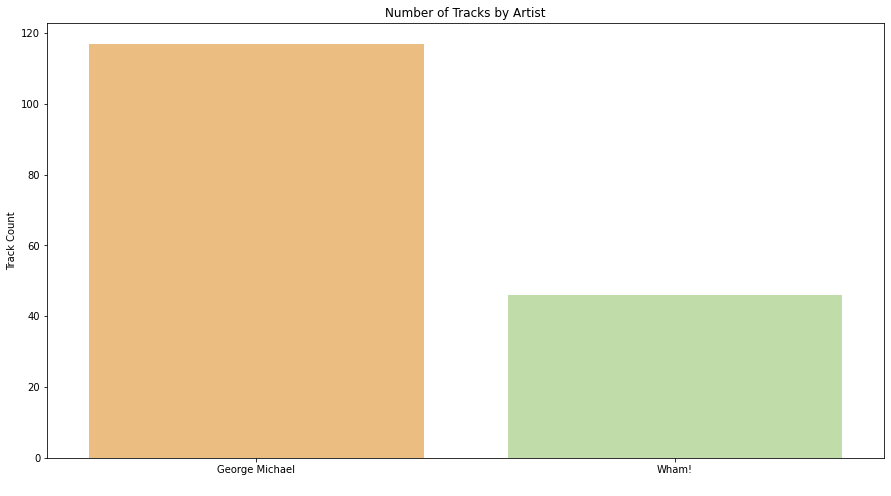

In [88]:
plt.figure(figsize=(15,8))
sns.barplot(data = tracks_pivot, x = tracks_pivot.index, y = 'track_name', palette = 'Spectral')
plt.xlabel(' ')
plt.ylabel('Track Count')
plt.title('Number of Tracks by Artist')

George Michael sadly passed away on 25/12/2016, and following his death there have been a handful of re-releases (mostly due to 2019 Christmas film 'Last Christmas' which some referred to as the worst film of the year), so I decided to filter those out too:

In [89]:
df = df[df['artist'].isin(['Wham!', 'George Michael'])]
df = df[df['release_date'] < '2016-12-25']
df.sample(5)

,Unnamed: 0,acousticness,album_name,album_type,analysis_url,artist,danceability,duration_ms,energy,id,...,release_date,speechiness,tempo,time_signature,track_href,track_name,type,uri,valence,album_year
258,258,0.37000,Faith,album,https://api.spotify.com/v1/audio-analysis/1JKT...,George Michael,0.772,277800.0,0.915,1JKTgiCDNoi4NQo8Rfhn8C,...,1987-10-30,0.0430,124.365,4.0,https://api.spotify.com/v1/tracks/1JKTgiCDNoi4...,Look at Your Hands - Remastered,audio_features,spotify:track:1JKTgiCDNoi4NQo8Rfhn8C,0.645,Faith (1987)
49,49,0.03350,Fantastic,album,https://api.spotify.com/v1/audio-analysis/55te...,Wham!,0.732,207933.0,0.836,55teLoqzgI0Wh9NjpSpWHA,...,1983-07-09,0.0593,146.367,4.0,https://api.spotify.com/v1/tracks/55teLoqzgI0W...,Love Machine - Instrumental Remix,audio_features,spotify:track:55teLoqzgI0Wh9NjpSpWHA,0.952,Fantastic (1983)
232,232,0.19300,Older,album,https://api.spotify.com/v1/audio-analysis/629U...,George Michael,0.345,181080.0,0.652,629U9r67L2Y47Jw9UqWbFP,...,1996-05-13,0.0619,83.479,4.0,https://api.spotify.com/v1/tracks/629U9r67L2Y4...,Free,audio_features,spotify:track:629U9r67L2Y47Jw9UqWbFP,0.164,Older (1996)
31,31,0.40100,Music From The Edge Of Heaven,album,https://api.spotify.com/v1/audio-analysis/28vp...,Wham!,0.699,392960.0,0.770,28vpMnsg4VC7ErY3rasiI6,...,1986-07-01,0.0740,118.432,4.0,https://api.spotify.com/v1/tracks/28vpMnsg4VC7...,Wham Rap '86,audio_features,spotify:track:28vpMnsg4VC7ErY3rasiI6,0.769,Music From The Edge Of Heaven (1986)
254,254,0.00509,Faith,album,https://api.spotify.com/v1/audio-analysis/6QnF...,George Michael,0.812,557293.0,0.600,6QnFHieoch6U9J8zfv6hml,...,1987-10-30,0.0538,99.189,4.0,https://api.spotify.com/v1/tracks/6QnFHieoch6U...,I Want Your Sex - Pts. 1 & 2 Remastered,audio_features,spotify:track:6QnFHieoch6U9J8zfv6hml,0.800,Faith (1987)


In [8]:
list(df.columns)

['Unnamed: 0',
 'acousticness',
 'album_name',
 'album_type',
 'analysis_url',
 'artist',
 'danceability',
 'duration_ms',
 'energy',
 'id',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'popularity',
 'release_date',
 'speechiness',
 'tempo',
 'time_signature',
 'track_href',
 'track_name',
 'type',
 'uri',
 'valence']

Next, I looked into my first question: whether George Michael was more sucessful as one half of Wham! or on his own. First I thought it would be useful to look into this by track and by album, so needed to tidy up the album and relrease date before plotting:

In [9]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['album_year'] = df['album_name'] + ' (' + df['release_date'].map(lambda dt: str(dt.year)) + ')' 


Next, I plotted these as a scatter plot using Spotify's composite rating of 'popularity', which is defined as follows:

'The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.' 

<AxesSubplot:title={'center':'Popularity of Tracks per Album'}, xlabel='Album, Year of Release', ylabel='Popularity'>

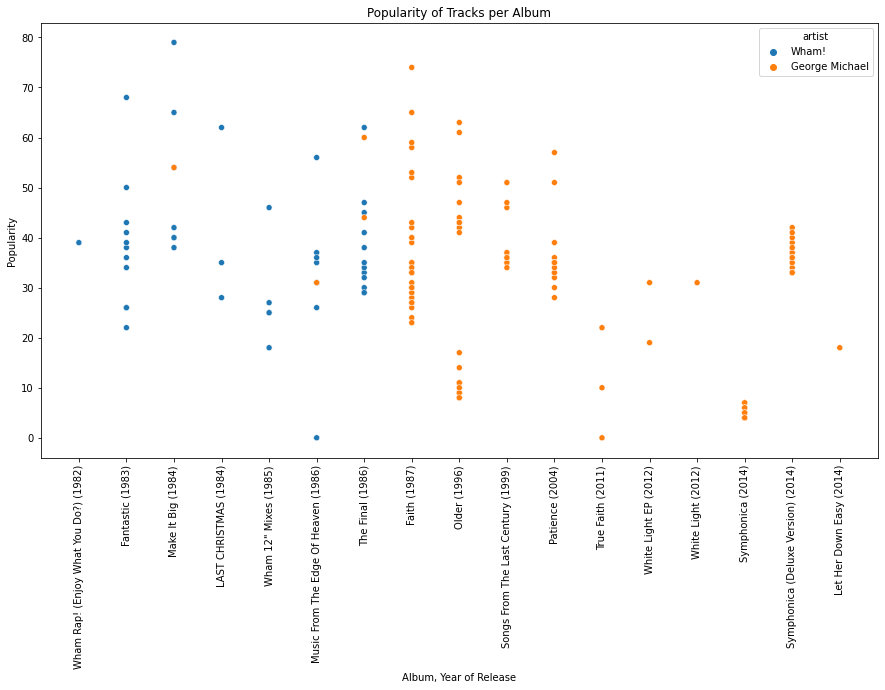

In [58]:
df.sort_values('release_date', ascending = True, inplace = True)
plt.figure(figsize=(15,8))
plt.xticks(rotation = 90)
plt.title('Popularity of Tracks per Album')
plt.xlabel('Album, Year of Release')
plt.ylabel('Popularity')

sns.scatterplot(x = df['album_year'], y = df['popularity'], hue = df['artist'])

It seemed to me that on the whole Wham! were more consistently successful that George Michael, but that George Michael reached higher and lower ratings than he did with Wham!

I decided to test this using a boxplot to answer the question once and for all:

Text(0, 0.5, ' ')

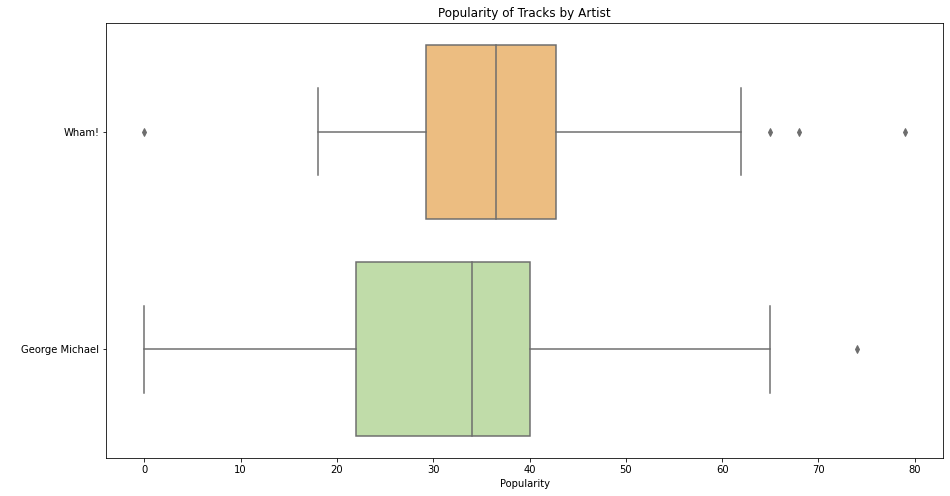

In [61]:
plt.figure(figsize=(15,8))
plt.title('Popularity of Tracks by Artist')

sns.boxplot(data = df, x= 'popularity', y = 'artist', palette = 'Spectral')
plt.xlabel('Popularity')
plt.ylabel(' ')


Finally I had my answer - Wham's hits were generally more popular than George Michael, but George Michael range was wider, and so reached higher highs and lower lows than Wham!

I was intrigued by the outliers - which were the very best and very worst hits? 

In [60]:
df[['artist', 'track_name', 'popularity']].sort_values('popularity').head(2)

,artist,track_name,popularity
35,Wham!,Last Christmas - Pudding Mix,0.0
279,George Michael,True Faith,0.0


In [30]:
df[['artist', 'track_name', 'popularity']].sort_values('popularity').tail(4)

,artist,track_name,popularity
37,Wham!,Everything She Wants,65.0
50,Wham!,Club Tropicana,68.0
252,George Michael,Faith - Remastered,74.0
36,Wham!,Wake Me up Before You Go-Go,79.0


Next up, I decided to look into the keys used, and a countplot seemed like the best way to go about this. 

Keys in my dataframe were represented by integers, and from the API documetation, I found the below explanation: 
'The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.'

This meant I would have to remember to change these from integers to strings in my plot. 

Text(0, 0.5, 'Track Count')

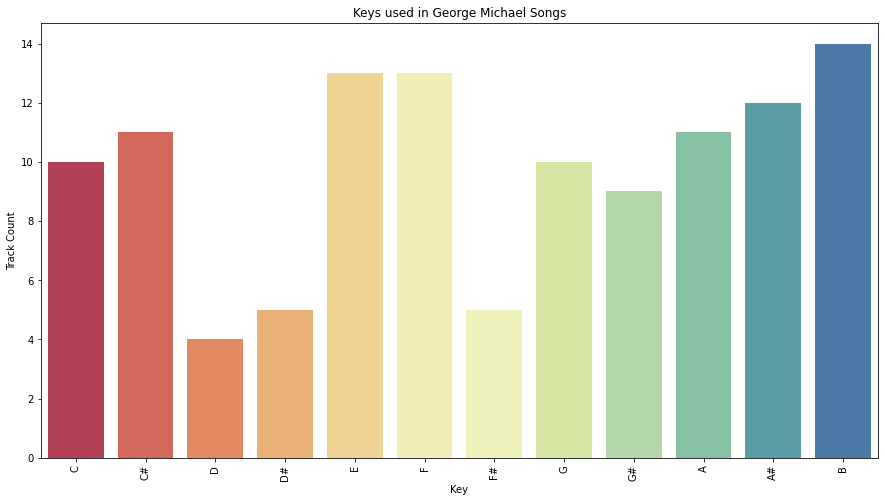

In [39]:
dfgm = df[df['artist']== 'George Michael'].sort_values('key')
dfgm['key']
plt.figure(figsize=(15,8))
plt.xticks(rotation = 90)
plt.title('Keys used in George Michael Songs')


keys = ["C","C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

dfgm['key'] = dfgm['key'].map(lambda i : keys[int(i)])

sns.countplot(x= dfgm['key'],palette = 'Spectral')
plt.xlabel('Key')
plt.ylabel('Track Count')

Text(0, 0.5, 'Track Count')

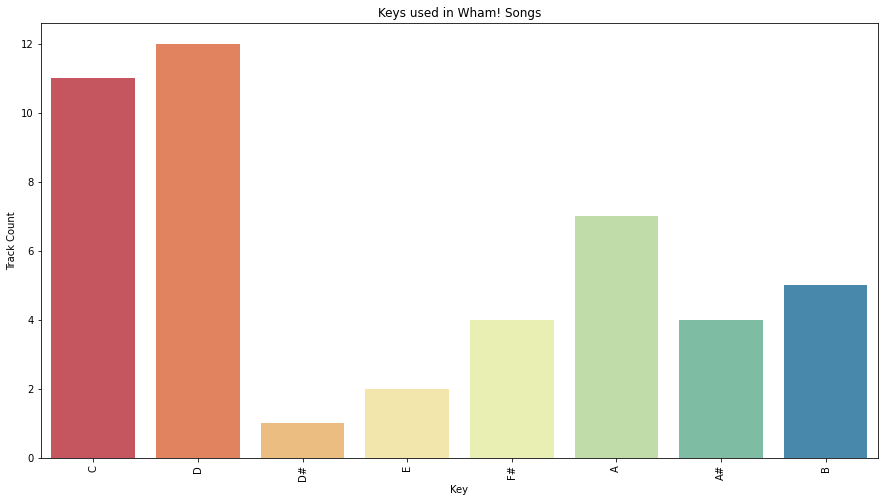

In [45]:
dfwham = df[df['artist']== 'Wham!'].sort_values('key')
plt.figure(figsize=(15,8))
plt.xticks(rotation = 90)

keys = ["C","C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

dfwham['key'] = dfwham['key'].map(lambda i : keys[int(i)])

sns.countplot(x= dfwham['key'], palette = 'Spectral')
plt.title('Keys used in Wham! Songs')
plt.xlabel('Key')
plt.ylabel('Track Count')

From this, it was clear that George Michael uses a must broader range of keys that Wham! did, so from this its possible to infer that Andre Ridgeley's vocal range was more limited than George Michael's. 

Additionally, I wanted to look into more acoustic songs. To do this, I thought best to look into the entire data set to get a larger sample size. I had made an assumption that these would normally be slower (lower tempo) than less acoustic songs. Both measures are defined below:

Acousticness: 
'A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. '

Tempo: 
'The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. '

Text(0, 0.5, 'Tempo (BPM)')

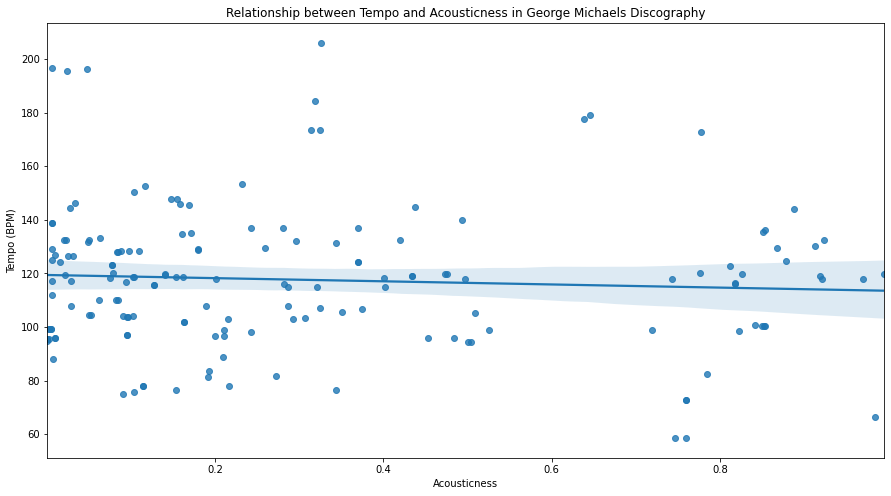

In [47]:
plt.figure(figsize=(15,8))
sns.regplot(x = df['acousticness'], y = df['tempo'])
plt.title('Relationship between Tempo and Acousticness in George Michaels Discography')
plt.xlabel('Acousticness')
plt.ylabel('Tempo (BPM)')
#No correlation 

I found there to be no correlation here, surprisingly. 
But what about acousticness and danceability? 

Danceability:

'Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.'

Text(0, 0.5, 'Danceability')

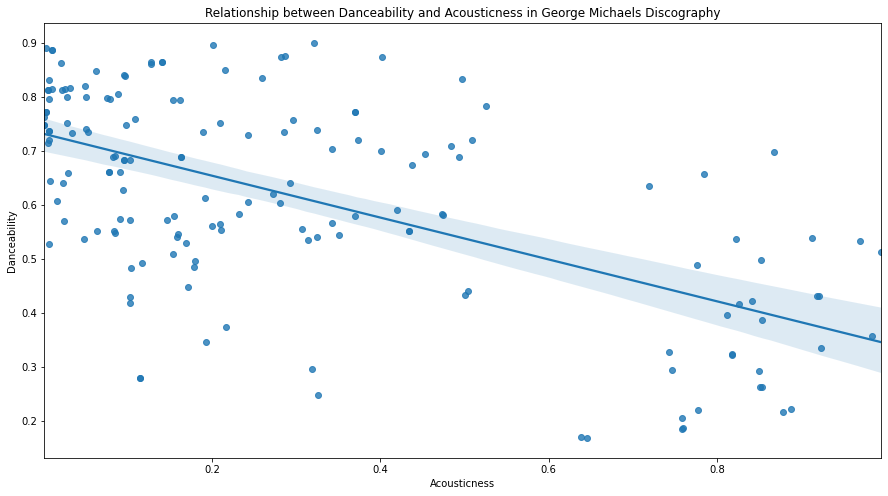

In [62]:
plt.figure(figsize=(15,8))
sns.regplot(x = df['acousticness'], y = df['danceability'])
plt.title('Relationship between Danceability and Acousticness in George Michaels Discography')
plt.xlabel('Acousticness')
plt.ylabel('Danceability')
#Very weak negative correlation

Indeed, I found that more acoustic songs tend to be less dancey than non acoustic songs. 

Finally, what about acousticness vs energy? 

'Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. '

Text(0, 0.5, 'Energy')

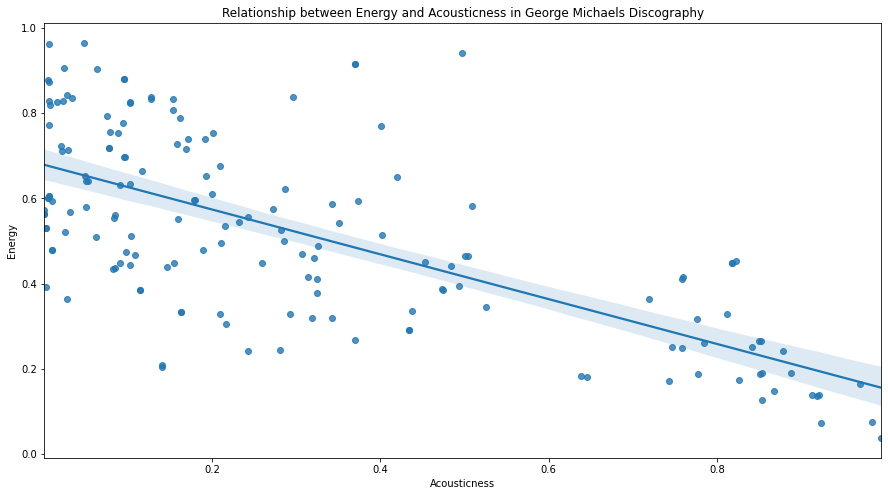

In [48]:
plt.figure(figsize=(15,8))
sns.regplot(x = df['acousticness'], y = df['energy'])
plt.title('Relationship between Energy and Acousticness in George Michaels Discography')
plt.xlabel('Acousticness')
plt.ylabel('Energy')
#negative correlation

From this, I also found negative correlation between energy and acousticness, the more acoustic a song is, the lower energy. 